# Superstore Sales: Clustering Analysis

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from helper_funcs import *
from sqlalchemy import create_engine, types
from sqlalchemy.types import *

import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [2]:
# SQLAlchemy Engine
engine = create_engine(generate_url())

## General EDA

In [3]:
df = pd.read_sql_table(table_name='features', con=engine.connect())
df.head(5)

,OrderYear,OrderMonth,DaysToShip,Segment,Region,State,Department,Division,Profit
0,2015,11,4,Corporate,East,Vermont,Furniture,Bookcases,1013.13
1,2016,1,4,Corporate,Central,Wisconsin,Furniture,Bookcases,407.13
2,2017,5,4,Consumer,South,Georgia,Furniture,Bookcases,374.63
3,2016,6,2,Consumer,South,Georgia,Furniture,Bookcases,291.38
4,2016,10,0,Corporate,East,Connecticut,Furniture,Bookcases,271.42


In [4]:
df.shape

(8058, 9)

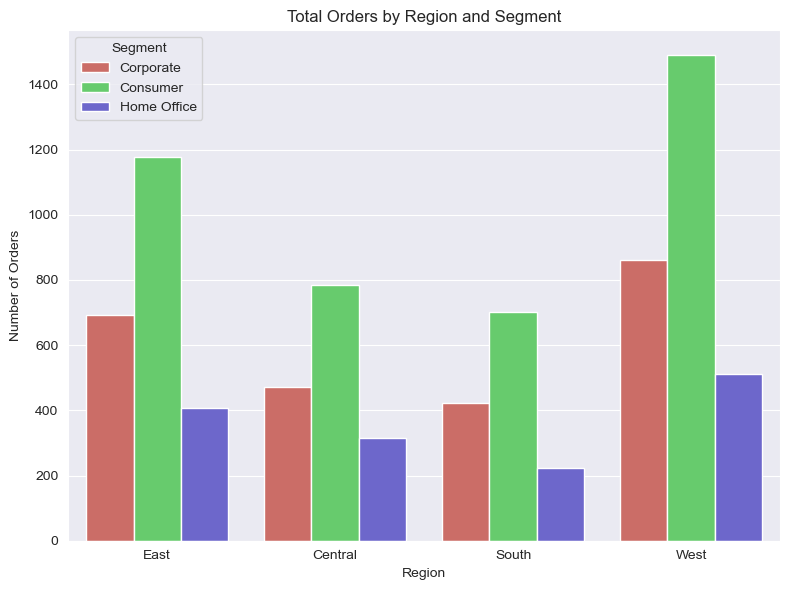

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x='Region', hue='Segment', ax=ax, palette=sns.color_palette('hls', 3))
ax.set_ylabel('Number of Orders')
ax.set_title('Total Orders by Region and Segment')
fig.tight_layout()
plt.show()

**REMARK**: Similar to our Copier inquery from out Categorical Analysis, West- and East-coast consumers lead total orders (volume). Also of note, Corporate orders outpace Home Office volume in all four regions.

In [6]:
# Selecting the 10 States with the most orders, aggregate Profit, and sort.
T10 = df['State'].value_counts()[:10].index.tolist()
top_state_df = df[df['State'].isin(T10)][['State', 'Profit']].groupby(by='State', as_index=False).sum().sort_values(by='Profit', ascending=False)

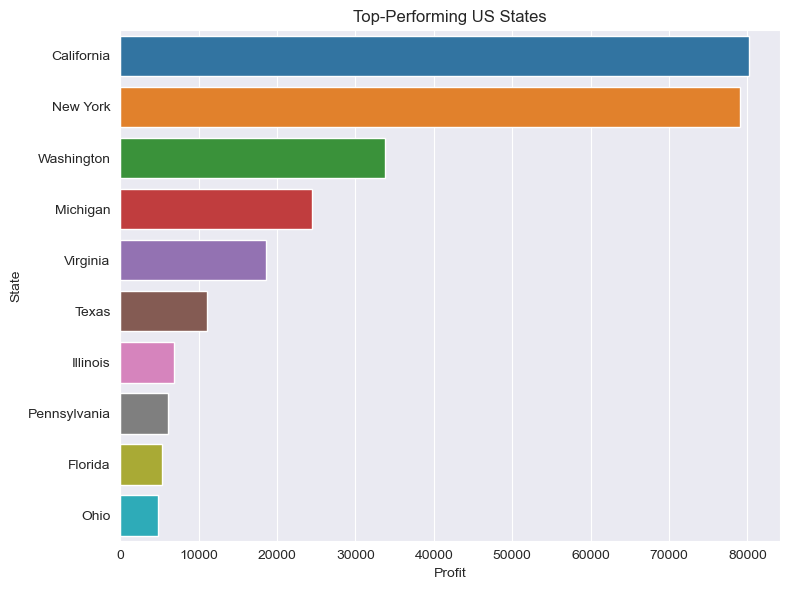

In [7]:
# Plot top_state_df
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=top_state_df, x='Profit', y='State', orient='h', ax=ax)
ax.set_title('Top-Performing US States')
fig.tight_layout()
plt.show()

**REMARK**: Unsurprisingly, California and New York compete for most Profitable (which here relates to most orders. Washington makes up roughly half of either, but Texas doesn't even make the Top 5.

## KMeans Clustering

SKLearn's OneHotEncoder may work too, but for our purposes, we're gonna do this quick and dirty.

In [8]:
# Detect columns as either numeric or categorical
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

print('Categorical Features:', cat_cols)
#cat_cols.tolist()

Categorical Features: ['Segment', 'Region', 'State', 'Department', 'Division']


In [9]:
# Encode categorical data with dummy variables, normalize numerical features, then concatenate back together.
norm_df = pd.concat([df[num_cols].apply(st.zscore), pd.get_dummies(df[cat_cols])], axis=1)
norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8058 entries, 0 to 8057
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   OrderYear                   8058 non-null   float64
 1   OrderMonth                  8058 non-null   float64
 2   DaysToShip                  8058 non-null   float64
 3   Profit                      8058 non-null   float64
 4   Segment_Consumer            8058 non-null   uint8  
 5   Segment_Corporate           8058 non-null   uint8  
 6   Segment_Home Office         8058 non-null   uint8  
 7   Region_Central              8058 non-null   uint8  
 8   Region_East                 8058 non-null   uint8  
 9   Region_South                8058 non-null   uint8  
 10  Region_West                 8058 non-null   uint8  
 11  State_Alabama               8058 non-null   uint8  
 12  State_Arizona               8058 non-null   uint8  
 13  State_Arkansas              8058 

In [10]:
# Correct a TypeError
norm_df.columns = norm_df.columns.astype(str)

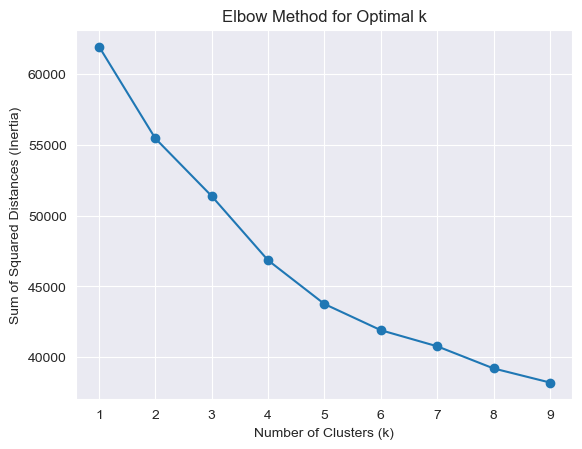

In [11]:
inertial_vals = []

K_vals  = range(1, 10)
for k in K_vals:
    kmeans = KMeans(k)
    kmeans.fit(norm_df)
    inertial_vals.append(kmeans.inertia_)

plt.plot(K_vals, inertial_vals, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.show()

In [12]:
kmeans = KMeans(n_clusters=5, random_state=101).fit(norm_df)
df['Cluster'] = kmeans.labels_

In [14]:
df['Cluster'].value_counts()

1    2411
2    2059
0    1989
3    1581
4      18
Name: Cluster, dtype: int64

### Cluster 1